# Mixtures of Gaussian processes with GPclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/jameshensman/gpclust> . The GPclust module depends on [GPy](https://github.com/SheffieldML/GPy).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252

A simple implementation of hierarchical GPs is available as part of GPy. You may also be interested in the related notebook on hierarchical GPs.


In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as n
import GPclust
import GPflow

## A simple sinusoid dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: smooth processes (here, sinusoids) corrupted by further smooth processes (here, more sinusoids) as well as noise. 

In [35]:
#generate a data set. Here's the sinusoid demo from the manuscript.
Nclust = 10
Nx = 12
Nobs = [np.random.randint(20,31) for i in range(Nclust)] #a random number of realisations in each cluster
X = np.random.rand(Nx,1)
X.sort(0)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(Nclust)-.5)
base_phases = 2*np.pi*np.random.rand(Nclust)
means = np.vstack([np.tile(np.sin(f*X+p).T,(Ni,1)) for f,p,Ni in zip(base_freqs,base_phases,Nobs)])

#add a lower frequency sinusoid for the noise
freqs = .4*np.pi + 0.01*(np.random.rand(means.shape[0])-.5)
phases = 2*np.pi*np.random.rand(means.shape[0])
offsets = 0.3*np.vstack([np.sin(f*X+p).T for f,p in zip(freqs,phases)])
Y = means + offsets + np.random.randn(*means.shape)*0.05

In the plot below, we show the underlying function for each cluster as a smooth red function, and the data associated with the cluster as thinly connected blue crosses. 

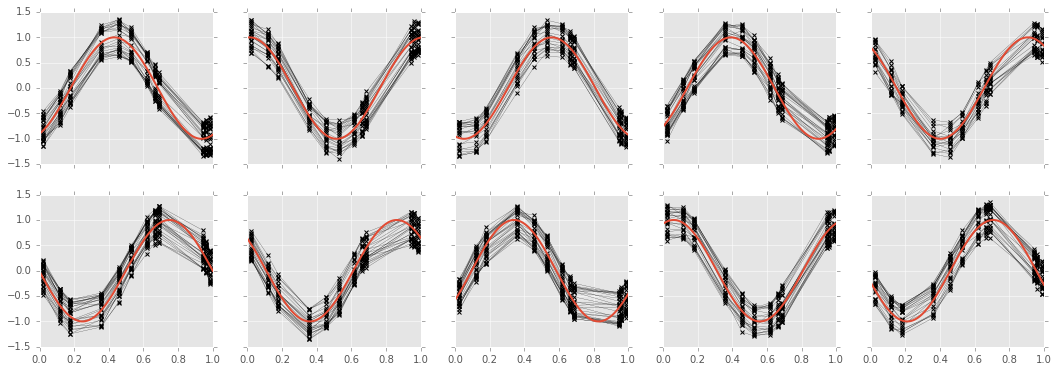

In [36]:
#plotting. 
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
f, axes = plt.subplots(2, Nclust//2, figsize=(18,6), sharex=True, sharey=True)
index_starts = np.hstack([0, np.cumsum(Nobs[:-1])])
index_stops = np.cumsum(Nobs)
for n, ax in enumerate(axes.flatten()):
    ax.plot(X, Y[index_starts[n]:index_stops[n]].T, 'k', marker='x',ms=4, mew=1, linewidth=0.2)
    ax.plot(x_plot, np.sin(base_freqs[n]*x_plot+base_phases[n]), linewidth=2)
    

Constructing and optimizing a model
---

Now that we have generated a data set, it's straightforward to build and optimize a clustering model. First, we need to build two GPy kernels (covariance functions), which will be used to model the underlying function and the replication noise, respecively. We'll take a wild stab at the parameters of these covariances, and let the model optimize them for us later. 

The two kernels model the *underlying* function of the cluster, and the deviations of each gene from that underlying function. If we believe that the only corruption of the data from the cluster mean is i.i.d. noise, we can specify a `GPy.kern.White` covariance. In practise, it's helpful to allow correlated noise. The model of any cluster of genes then has a hierarchical structure, with the unknown cluster-specific mean drawn from a GP, and then each gene in that cluster being drawn from a GP with said unknown mean function. 

To optimize the model with the default optimization settings, we call m.optimize(). To invoke the recommended merge-split procedure, call m.systematic_splits(). Note that during the splitting procedure, many calls are made to the optimize function. 

In [37]:
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.RBF(input_dim=1, variance=0.01, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.001)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-6508.42534587 grad=21795.6240451, beta=0
iteration 2 bound=19.2250410123 grad=38700.3461962, beta=0.941784597848
iteration 3 bound=318.617323956 grad=429.505744163, beta=0.0
iteration 4 bound=630.504410585 grad=1146.39201729, beta=0.0
iteration 5 bound=666.584001246 grad=43.8701022468, beta=0.0307126844866
iteration 6 bound=666.887839354 grad=0.620805125544, beta=0.00871739302552
iteration 7 bound=666.91363167 grad=0.042278533897, beta=0.144963121662
iteration 8 bound=666.91372821 grad=0.000166150146257, beta=0.0167435610793
iteration 9 bound=666.913729352 grad=2.5893745061e-06, beta=0.047536891321
iteration 10 bound=666.913729643 grad=4.79373493886e-07, beta=0.0
vb converged (ftol)
compiling tensorflow function...
done
optimization terminated, setting model state
vb converged (gtol)
optimization terminated, setting model state
optimization terminated, setting model state
optimization terminated, setting model state
optimization terminated, setting model state
optimi

Plotting and examining the posterior
---
The model has quite extensive plotting built in, with various options for colour, display of the data as points or connected lines, etc. Here we find that the model manages to separate all but two of the true clusters. The number of 'genes' found in each cluster is labeled in the corner of each plot. 

/Users/james/anaconda/envs/py35-tf10/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


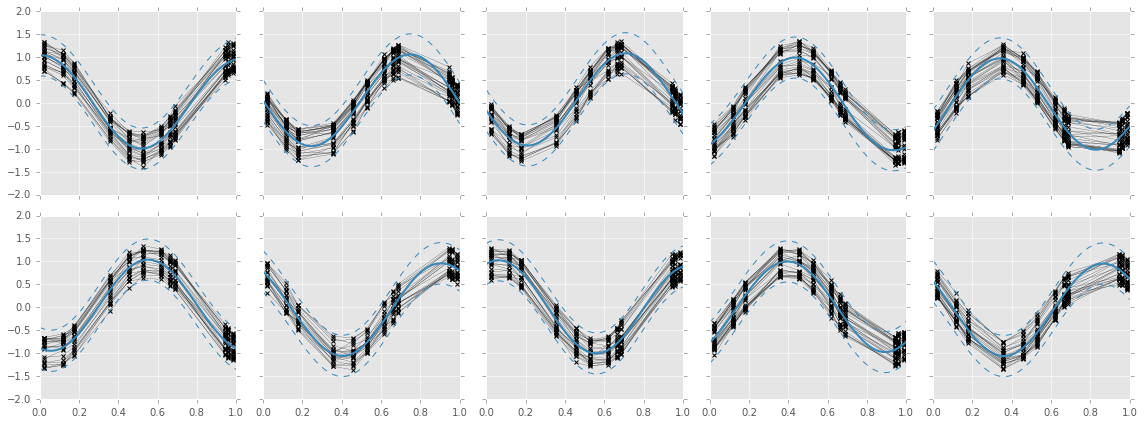

In [38]:

def plot(layout=None, figsize=(12,12)):
    if layout is None:
        num_x = int(np.ceil(np.sqrt(m.num_clusters)))
        num_y = m.num_clusters // num_x
    else:
        num_x, num_y = layout
    f, axes = plt.subplots(num_x, num_y, figsize=figsize, sharex=True, sharey=True, tight_layout=True)
    
    x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
    mu, var = m.predict_components(x_plot)
    phi = m.get_phi()
    
    for i, (mu_i, var_i, ax), in enumerate(zip(mu, var, axes.flatten())):
        ax.plot(x_plot[:,0], mu_i)

        ind = np.argmax(phi, 1) == i
        if np.any(ind):
            ax.plot(X, Y[ind, :].T, 'k', ms=4, mew=1, marker='x', lw=0.2)
        line, = ax.plot(x_plot[:,0], mu_i, lw=2)
        ax.plot(x_plot[:,0], mu_i[:,0] + 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
        ax.plot(x_plot[:,0], mu_i[:,0] - 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
plot((2,5), (16,6))

Structure is important
---
Why do we have to specify two kernels in GPclust? The first kernel describes the properties of the functions which underly each cluster. The second describes the properties of the functions which describe how each time-course (gene) deviates from the cluster. 

This structure is important: if we model the deviation of each time-course from the cluster as simply noise, it's more difficult to infer the correct clusters. Such a model can be constructed in GPclust by using a white (noise) kernel for the structure, as follows.


In [39]:
#exactly as above, but with a white-noise kernel for the structure.
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.White(1, variance=0.1)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-2770.8639291 grad=1319.30742362, beta=0
iteration 2 bound=-1022.27044108 grad=44026.9027852, beta=3.09749908303
iteration 3 bound=-751.018710984 grad=457.997473955, beta=0.0
iteration 4 bound=-654.846236199 grad=180.430944303, beta=0.0
iteration 5 bound=-639.50822283 grad=36.961062817, beta=0.0
iteration 6 bound=-634.91879291 grad=5.17670628925, beta=0.0667041300572
iteration 7 bound=-631.591663989 grad=2.56726533788, beta=0.503268901086
iteration 8 bound=-629.985378644 grad=1.12062210905, beta=0.243737356859
iteration 9 bound=-627.495328644 grad=1.73887706424, beta=0.0
iteration 10 bound=-611.150837563 grad=5.41922960787, beta=1.97513458584
iteration 11 bound=-595.996393805 grad=15.6537019866, beta=1.40306888343
iteration 12 bound=-595.546143037 grad=0.696333441442, beta=0.0
iteration 13 bound=-595.503915878 grad=0.0653184317724, beta=0.25193849616
iteration 14 bound=-595.493402751 grad=0.0193363466717, beta=0.0
iteration 15 bound=-595.493197319 grad=0.0003940291598

/Users/james/anaconda/envs/py35-tf10/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


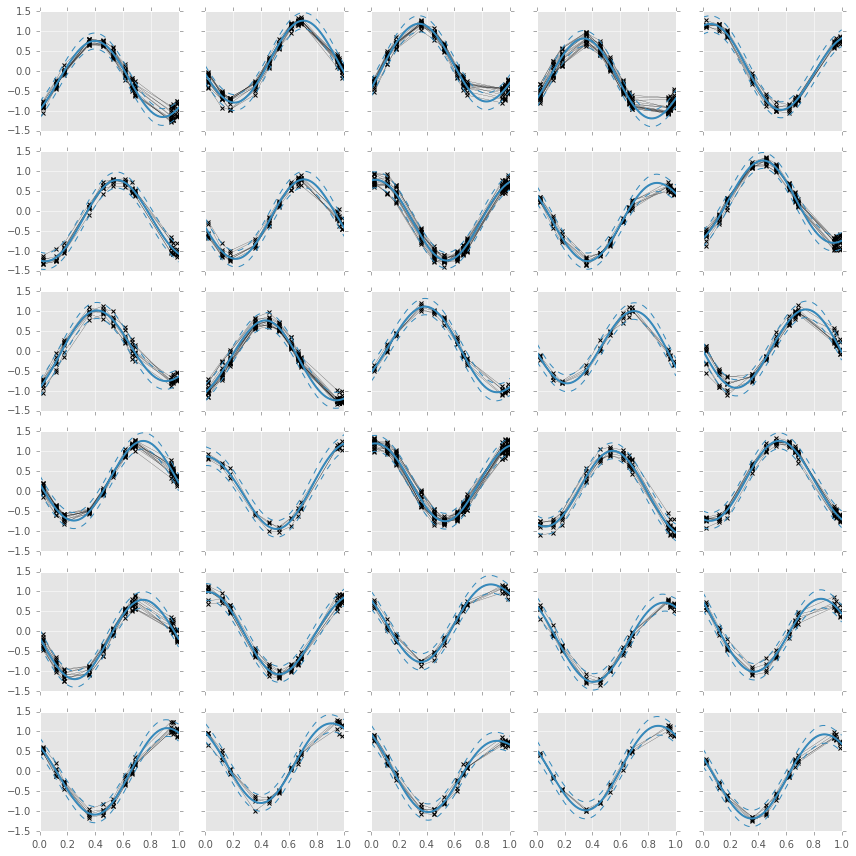

In [40]:
plot()

Here we can see that the procedure finds too many clusters (we know that the ground truth is that there are 10). This is because without the ability to model the deviation from the cluster mean in a structured fashion, that structure appears as additional clusters. 

This point is exaggerated a little by the toy data that we have generated, but the same issue exists in real data. For more details and consideration of the cluster structure, see the subsequent notebook on clustering Drosophila development. 